# 5.4 Modeling multi-body interactions

#### This notebook provides an example of how to use the map equation to uncover modular structure in a hypergraph, by representing it as a bipartite, or multilayer network.

In [1]:
!git clone https://github.com/mapequation/mapping-hypergraphs.git

fatal: destination path 'mapping-hypergraphs' already exists and is not an empty directory.


In [2]:
!cargo build --release --manifest-path mapping-hypergraphs/create-representations/Cargo.toml

    Finished `release` profile [optimized] target(s) in 0.01s


Usage
```
cargo run -- representation hypergraph outfile
```
Where `representation` can be any of `-[b|B|u|U|m|M|hs|HS]` 

| Flag   | Network representation        |
|--------|-------------------------------|
| `-b`   | bipartite                     |
| `-B`   | bipartite non-lazy            |
| `-u`   | unipartite                    |
| `-U`   | unipartite non-lazy           |
| `-m`   | multilayer                    |
| `-M`   | multilayer non-lazy           |
| `-hs`  | hyperedge-similarity          |
| `-HS`  | hyperedge-similarity non-lazy |

#### Hypergraph Input Format

The hypergraph input file contains three sections:

1. **Vertices**  
   Each vertex has a numeric ID and an optional string label.

2. **Hyperedges**  
   Each hyperedge lists:
   - its ID  
   - the nodes it contains  
   - a hyperedge weight `omega`

3. **Weights (optional)**  
   Per-node hyperedge weights `gamma`.  
   If omitted, all node–hyperedge incidences default to **1**.

#### Example Hypergraph File

In [3]:
# *Vertices
# # id [name]
# 1 "a"
# 2 "b"
# 3 "c"
# 4 "d"
# 5 "f"
# *Hyperedges
# # id nodes... omega
# 1 1 2 3 1
# 2 3 4 5 1
# *Weights
# # edge node gamma
# 1 1 1
# 1 2 1
# 1 3 2
# 2 3 2
# 2 4 1
# 2 5 1

In [4]:
from infomap import Infomap
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import subprocess
from pathlib import Path
import seaborn as sns
from coloraide import Color
import sys

In [5]:
def convert_hypergraph(input_filename, output_filename, representation_flag="-b"):
    """
    Convert a hypergraph file to a network representation using the Rust tool.

    Parameters
    ----------
    input_filename : str
        Path to the hypergraph file.
    output_filename : str
        Path for the output network file.
    representation_flag : str
        One of the supported network representation flags, default '-b' for bipartite.
    """
    input_path = Path(input_filename).resolve()
    output_path = Path(output_filename).resolve()

    cargo_manifest = Path("mapping-hypergraphs/create-representations/Cargo.toml").resolve()

    cmd = [
        "cargo", "run",
        "--manifest-path", str(cargo_manifest),
        "--",
        representation_flag,
        str(input_path),
        str(output_path)
    ]

    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)

# Example 1: Represent the input hypergraph as a bipartite network
convert_hypergraph(
    input_filename="mapping-hypergraphs/data/example-paper.txt",
    output_filename="output/example_bipartite.net",
    representation_flag="-b"
)

# Example 2: Represent the input hypergraph as a multilayer network
convert_hypergraph(
    input_filename="mapping-hypergraphs/data/example-paper.txt",
    output_filename="output/example_multilayer.net",
    representation_flag="-m"
)

Running: cargo run --manifest-path /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/mapping-hypergraphs/create-representations/Cargo.toml -- -b /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/mapping-hypergraphs/data/example-paper.txt /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/output/example_bipartite.net


    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.01s
     Running `mapping-hypergraphs/create-representations/target/debug/create-representations -b /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/mapping-hypergraphs/data/example-paper.txt /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/output/example_bipartite.net`


Preprocessing...
Generating lazy bipartite...
Done!
Running: cargo run --manifest-path /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/mapping-hypergraphs/create-representations/Cargo.toml -- -m /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/mapping-hypergraphs/data/example-paper.txt /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/output/example_multilayer.net
Preprocessing...
Generating lazy multilayer...
Done!


    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.00s
     Running `mapping-hypergraphs/create-representations/target/debug/create-representations -m /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/mapping-hypergraphs/data/example-paper.txt /Users/jelena/Desktop/Infomap/infomap-tutorial-notebooks-main/output/example_multilayer.net`


In [6]:
# Identify network modules using Infomap

def run_infomap(filename: str, columns=["node_id", "name", "flow", "module_id"], **infomap_args):
    im = Infomap(silent=True, **infomap_args)
    im.read_file(filename)
    im.run()
    return im.get_dataframe(columns=columns)

In [7]:
# Example 1: Bipartite network representation, where physical nodes and hyperedges are modeled as distinct node sets

filename_bipartite = "output/example_bipartite.net"
df_infomap_bipartite = run_infomap(filename_bipartite, skip_adjust_bipartite_flow=False).set_index("node_id")
df_infomap_bipartite

,name,flow,module_id
node_id,,,
7,i,0.179775,1
9,g,0.168539,1
8,h,0.089888,1
10,j,0.089888,1
14,Hyperedge 4,0.000000,1
15,Hyperedge 5,0.000000,1
3,c,0.157303,2
6,f,0.112360,2
1,a,0.089888,2


In [8]:
# Example 2: Multilayer network representation, with each hyperedge forming a separate layer

filename_multilayer = "output/example_multilayer.net"
df_infomap_multilayer = run_infomap(filename_multilayer, ["state_id", "node_id", "layer_id", "name", "flow", "module_id"]).set_index("state_id")
df_infomap_multilayer

,node_id,layer_id,name,flow,module_id
state_id,,,,,
12,7,5,i,0.100977,1
15,10,5,j,0.092100,1
11,9,4,g,0.091878,1
9,7,4,i,0.089215,1
14,9,5,g,0.053263,1
13,8,5,h,0.052708,1
10,8,4,h,0.047271,1
5,9,3,g,0.035952,1
2,3,1,c,0.093742,2


#### Visualize the hypergraph as a bipartite network. Nodes and hyperedges are colored according to their detected communities.

In [9]:
sys.path.append("mapping-hypergraphs")
from hypergraph.network.hypergraph import HyperGraph

def parse_hypergraph(filename):
    with open(filename) as fp:
        H = HyperGraph.from_iter(fp)
        return H
    
H = parse_hypergraph("mapping-hypergraphs/data/example-paper.txt")


In [10]:
def create_bipartite_graph(H : HyperGraph):
    weights = {(g.edge, g.node.id): g.gamma for g in H.weights}
    G = nx.Graph()
    N = len(H.nodes)
    for node in H.nodes:
        G.add_node(node.id, name=node.name, node_type="physical")
    for edge in H.edges:
        G.add_node(edge.id+N, name=edge.id, node_type="hyperedge")
        for n in edge.nodes:
            G.add_edge(edge.id+N, n.id, weight=weights[(edge.id, n.id)])
    return G

G = create_bipartite_graph(H)


In [11]:
# Save Infomap modules as node attributes
for n in G:
    G.nodes[n]["module_id"] = df_infomap_bipartite.loc[n, 'module_id']

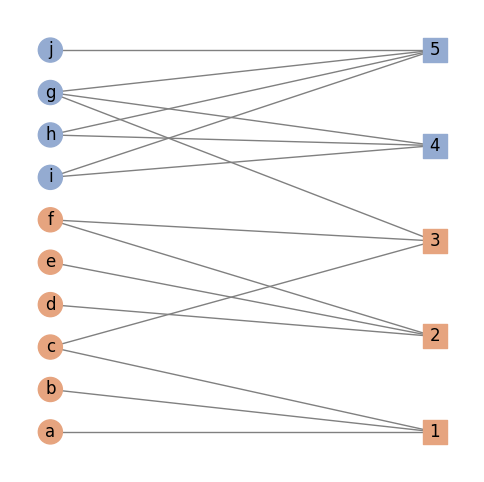

In [12]:
# Create a color palette
palette = sns.color_palette("deep").as_hex()
palette = [Color(c).set("hsl.lightness", 0.7) for c in palette]
palette = sns.palettes._ColorPalette(palette)

def draw_bipartite_graph(G: nx.Graph):
    # Split nodes by type
    physical_nodes = [n for n in G if G.nodes[n]["node_type"] == "physical"]
    hyperedge_nodes = [n for n in G if G.nodes[n]["node_type"] == "hyperedge"]

    # Map nodes to colors based on their module_id
    node_colors = {n: palette[G.nodes[n]["module_id"] - 1] for n in G.nodes}

    # Generate bipartite layout using physical nodes as anchors
    pos = nx.bipartite_layout(G, physical_nodes)

    plt.figure(figsize=(6, 6))

    # Draw physical nodes as circles
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=physical_nodes,
        node_color=[node_colors[n] for n in physical_nodes],
        node_shape='o',  # circle
        node_size=300,
    )

    # Draw hyperedges as squares
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=hyperedge_nodes,
        node_color=[node_colors[n] for n in hyperedge_nodes],
        node_shape='s',  # square
        node_size=300,
    )

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, "name"))

    plt.axis('off')
    plt.show()

draw_bipartite_graph(G)